In [2]:
import os
import numpy as np
import librosa

# 定义数据路径
base_path = r"D:\Dataset\Temp_Results\Train_Test"
output_path = r"D:\Dataset\Temp_Results\SNRandLHR"
os.makedirs(output_path, exist_ok=True)

# 读取音频数据和对应的采样率及 ID
X_train = np.load(os.path.join(base_path, "X_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(base_path, "X_test.npy"), allow_pickle=True)
sr_train = np.load(os.path.join(base_path, "sr_train.npy"), allow_pickle=True)
sr_test = np.load(os.path.join(base_path, "sr_test.npy"), allow_pickle=True)
ids_train = np.load(os.path.join(base_path, "ids_train.npy"), allow_pickle=True)
ids_test = np.load(os.path.join(base_path, "ids_test.npy"), allow_pickle=True)

def compute_snr_lhr_adaptive(signal, sample_rate):
    fft_signal = np.fft.fft(signal)
    psd_signal = np.abs(fft_signal) ** 2
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)
    freqs = freqs[:len(freqs) // 2]
    psd_signal = psd_signal[:len(psd_signal) // 2]
    
    spectral_centroid = np.sum(freqs * psd_signal) / (np.sum(psd_signal) + 1e-8)
    geometric_mean = np.exp(np.mean(np.log(psd_signal + 1e-8)))
    arithmetic_mean = np.mean(psd_signal)
    sfm = geometric_mean / (arithmetic_mean + 1e-8)
    threshold = np.percentile(psd_signal, 90 * (1 - sfm))
    signal_power = np.sum(psd_signal[psd_signal > threshold])
    noise_power = np.sum(psd_signal[psd_signal <= threshold])
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    
    low_freq_power = np.sum(psd_signal[freqs < spectral_centroid])
    high_freq_power = np.sum(psd_signal[freqs >= spectral_centroid])
    lhr = low_freq_power / (high_freq_power + 1e-8)
    
    return snr, lhr

def process_audio_data(X, sr, ids, set_name):
    snr_lhr_list = []
    
    for i, signal in enumerate(X):
        snr, lhr = compute_snr_lhr_adaptive(signal, sr[i])
        snr_lhr_list.append([ids[i], snr, lhr])
    
    snr_lhr_array = np.array(snr_lhr_list, dtype=object)
    np.save(os.path.join(output_path, f"SNR_LHR_{set_name}.npy"), snr_lhr_array)
    print(f"✅ {set_name} 数据处理完成，结果已保存。")

# 处理训练和测试数据
process_audio_data(X_train, sr_train, ids_train, "train")
process_audio_data(X_test, sr_test, ids_test, "test")


✅ train 数据处理完成，结果已保存。
✅ test 数据处理完成，结果已保存。


In [1]:
import numpy as np

# 取消 NumPy 的打印省略
np.set_printoptions(threshold=np.inf)

# 读取数据
X_train_SNR_LHR = np.load(r"D:\Dataset\Temp_Results\SNRandLHR\SNR_LHR_train.npy", allow_pickle=True)

# 打印完整数据
print(X_train_SNR_LHR)

[[np.str_('5903700F_seg0') np.float32(25.175419) np.float32(14.649713)]
 [np.str_('59037013_seg7') np.float32(21.275179) np.float32(6.195104)]
 [np.str_('5903700G_seg6') np.float32(27.6208) np.float32(17.714106)]
 [np.str_('61025003_seg1') np.float32(18.981396) np.float32(19.531454)]
 [np.str_('5903700Q_seg0') np.float32(22.08535) np.float32(19.839233)]
 [np.str_('6102500R_seg0') np.float32(18.158762) np.float32(32.219822)]
 [np.str_('6102500R_seg30') np.float32(19.574175) np.float32(35.30097)]
 [np.str_('7200500L_seg1') np.float32(10.416161) np.float32(1.6890883)]
 [np.str_('61072032_seg51') np.float32(14.809665) np.float32(5.309457)]
 [np.str_('6102602K_seg0') np.float32(10.205488) np.float32(0.601369)]
 [np.str_('72005003_seg1') np.float32(8.019759) np.float32(1.6712849)]
 [np.str_('7001300E_seg1') np.float32(12.985128) np.float32(0.3614526)]
 [np.str_('79004007_seg2') np.float32(14.170954) np.float32(1.4789195)]
 [np.str_('72005001_seg0') np.float32(9.795495) np.float32(3.0866795)]

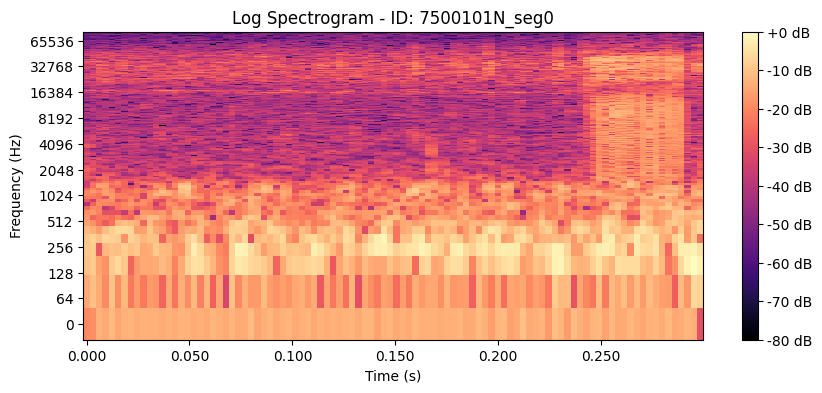

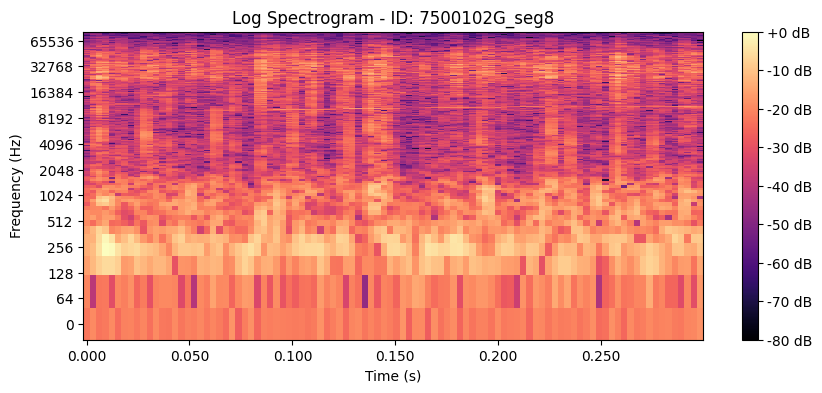

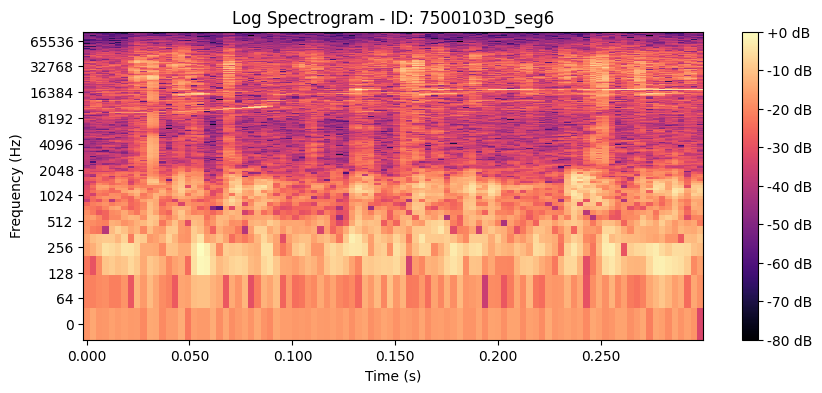

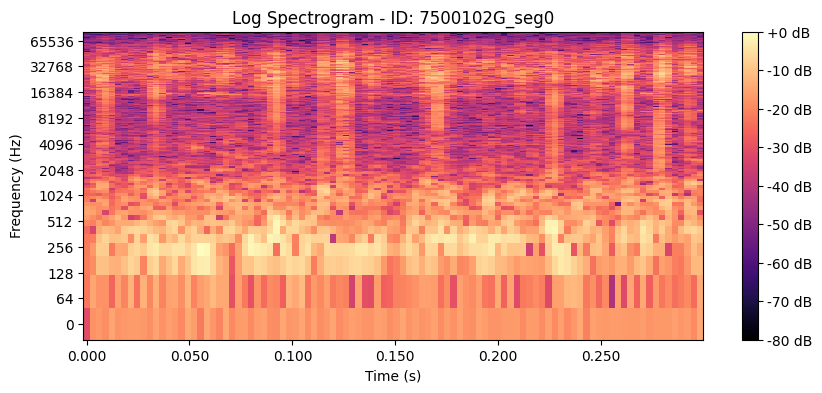

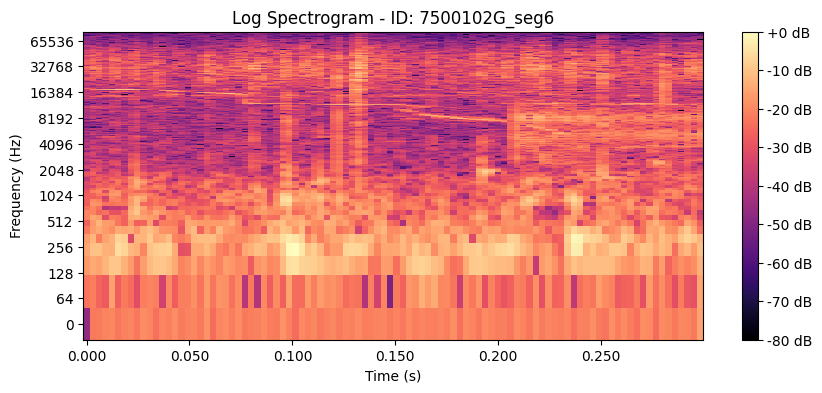

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

# 加载 SNR_LHR 训练数据
snr_lhr_train = np.load(os.path.join(output_path, "SNR_LHR_train.npy"), allow_pickle=True)

# 筛选 SNR < 10 的 ID
low_snr_ids = [entry[0] for entry in snr_lhr_train if entry[1] > 20]
low_snr_indices = [i for i, id_val in enumerate(ids_train) if id_val in low_snr_ids]

# 处理低 SNR 音频数据
for idx in low_snr_indices:
    signal = X_train[idx]
    sr = sr_train[idx]
    
    # 绘制时频图
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log Spectrogram - ID: {ids_train[idx]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()
    
    # 播放音频
    display(ipd.Audio(signal, rate=sr))
